# Project M9: Exoplanet detection using the transit method

Marko Raidlo, Raido Everest

In [1]:
# We will uniformly use random state = 3 for replicability of results.

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
#plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 30})

import numpy as np
import pandas as pd
from scipy import ndimage, fft
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

## Loading in the datasets

In [2]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')
    
train.columns = [train.columns[i].replace("FLUX.", "") for i in range(len(train.columns))]
test.columns = [test.columns[i].replace("FLUX.", "") for i in range(len(test.columns))]
    
#Replacing 2s and 1s with 1s and 0s.
train.LABEL = train.LABEL.replace(1, 0)
train.LABEL = train.LABEL.replace(2, 1)
test.LABEL = test.LABEL.replace(1, 0)
test.LABEL = test.LABEL.replace(2, 1)
    
#X and Y datasets
train_X = train.drop('LABEL', axis=1)
train_Y = train["LABEL"]

test_X = test.drop('LABEL', axis=1)
test_Y = test["LABEL"]

train_X.head()

,1,2,3,4,5,6,7,8,9,10,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Preprocessing

In [3]:
def fourier(df):
        return np.abs(fft(df, n=df.size))

def pre_process(df):
    #Preprocessing method applies:
    # Fourier transform
    # Normalization
    # Gaussian filter
    # Standardization
    
    #Fourier
    df_copy = df.copy()
    df_copy = df_copy.apply(fourier ,axis=1)
    
    df_copy = pd.DataFrame(df_copy.tolist())
    df_copy  = df_copy.iloc[:,0:df_copy.shape[1]//2]
    
    # Normalize
    df_copy = pd.DataFrame(normalize(df_copy))

    # Gaussian filter to smooth out data
    df_copy = ndimage.filters.gaussian_filter(df_copy, sigma=10)

    # Standardize X data
    std_scaler = StandardScaler()
    df_copy = std_scaler.fit_transform(df_copy)
    
    return pd.DataFrame(df_copy)

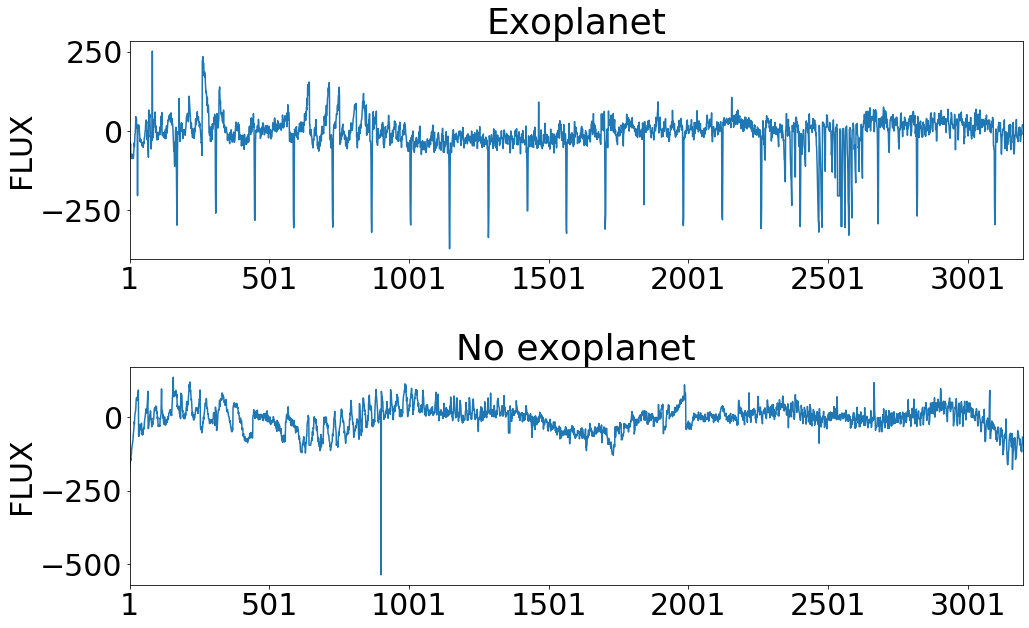

In [4]:
#Pre process plot

plt.subplot(211)
plt.title("Exoplanet")
train_X.iloc[1].plot()
plt.ylabel("FLUX")
plt.subplot(212)
plt.title("No exoplanet")
train_X.iloc[3213].plot()
plt.ylabel("FLUX")

plt.subplots_adjust(hspace=0.5)
#plt.savefig('fig1.png', dpi = 1000)
plt.show()

In [5]:
# Processing data
train_X = pre_process(train_X)
test_X = pre_process(test_X)

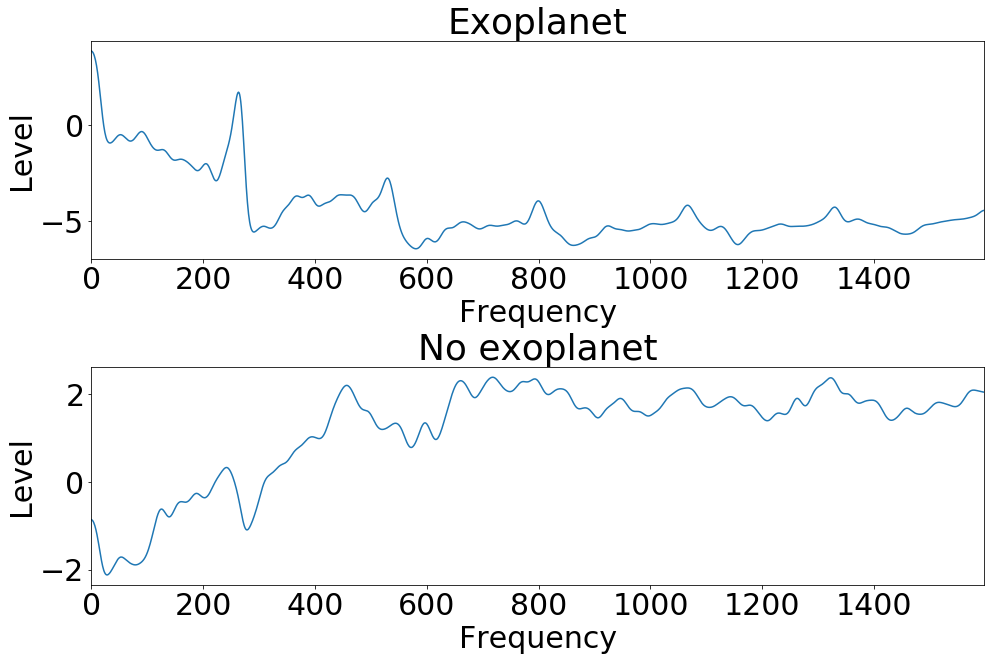

In [6]:
#Post process plot

plt.subplot(211)
plt.title("Exoplanet")
train_X.iloc[1].plot()
plt.ylabel("Level")
plt.xlabel("Frequency")
plt.subplot(212)
plt.title("No exoplanet")
train_X.iloc[3213].plot()
plt.ylabel("Level")
plt.xlabel("Frequency")

plt.subplots_adjust(hspace=0.5)
#plt.savefig('fig2.png', dpi = 1000)
plt.show()

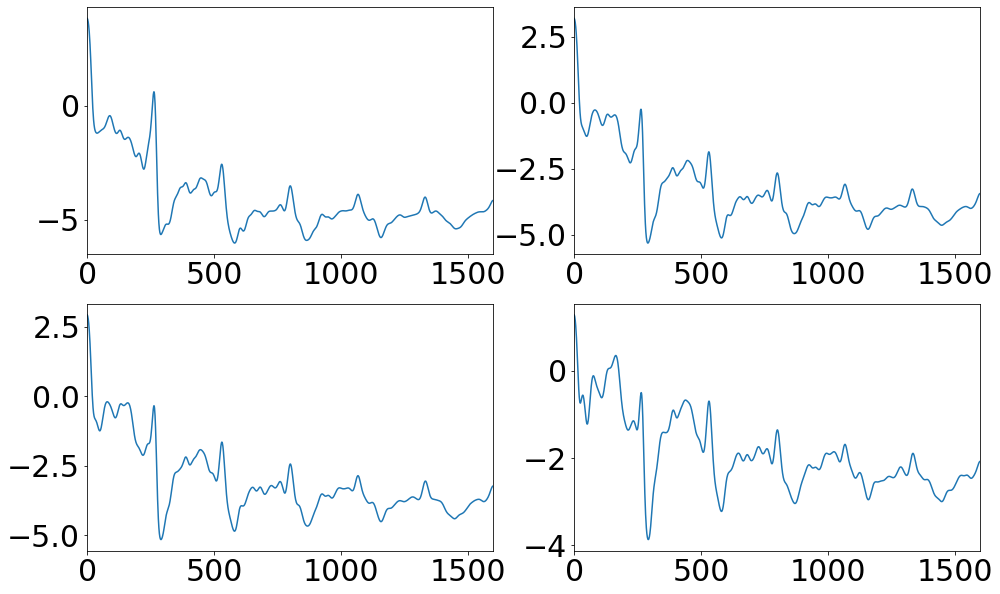

In [7]:
# Exoplanet star results
plt.subplot(221)
train_X.iloc[12].plot()
plt.subplot(222)
train_X.iloc[21].plot()
plt.subplot(223)
train_X.iloc[23].plot()
plt.subplot(224)
train_X.iloc[32].plot()
#plt.savefig('fig3.png', dpi = 1000)

plt.show()

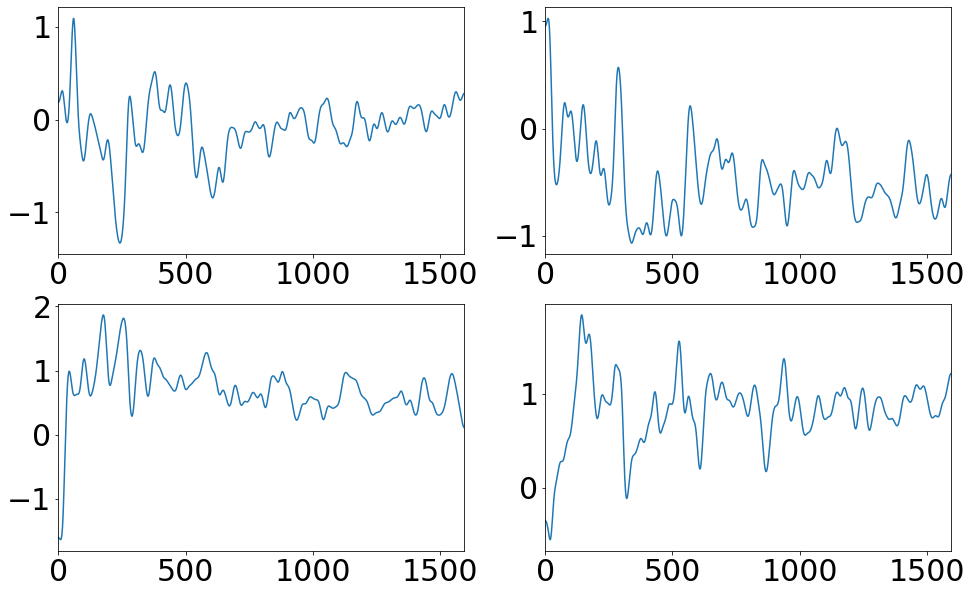

In [8]:
# Non exoplanet star results
plt.subplot(221)
train_X.iloc[1111].plot()
plt.subplot(222)
train_X.iloc[2231].plot()
plt.subplot(223)
train_X.iloc[4512].plot()
plt.subplot(224)
train_X.iloc[1233].plot()
#plt.savefig('fig4.png', dpi = 1000)

plt.show()

## Building models

In [9]:
#Evaluation method:

def evaluate(model):
    train_result =  model.predict(train_X)
    test_result = model.predict(test_X)
    confm_train = confusion_matrix(train_Y, train_result)
    confm_test = confusion_matrix(test_Y, test_result)
    
    acc_train = accuracy_score(train_Y, train_result)
    acc_test = accuracy_score(test_Y, test_result)
    pre_train = precision_score(train_Y, train_result)
    pre_test = precision_score(test_Y, test_result)
    rec_train = recall_score(train_Y, train_result)
    rec_test = recall_score(test_Y, test_result)
    auc_train = roc_auc_score(train_Y, train_result)
    auc_test = roc_auc_score(test_Y, test_result)
    
    print("------------------Evaluation------------------")
    print("On training set:")
    print("Accuracy:", acc_train)
    print("Precision:", pre_train)
    print("Recall:", rec_train)
    print("AUC score:", auc_train)
    print("Confusion matrix:")
    print(confm_train)
    print("----------------------------------------------")
    print("On test set:")
    print("Accuracy:", acc_test)
    print("Precision:", pre_test)
    print("Recall:", rec_test)
    print("AUC score:", auc_test)
    print("Confusion matrix:")
    print(confm_test)
    print("--------------End of valuation----------------")

### Logistic Regression

In [10]:
model_log = LogisticRegression(random_state = 3, solver='lbfgs')
model_log.fit(train_X, train_Y)

evaluate(model_log)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9947368421052631
Precision: 0.625
Recall: 1.0
AUC score: 0.9973451327433629
Confusion matrix:
[[562   3]
 [  0   5]]
--------------End of valuation----------------


### Support Vector Machine

In [11]:
model_svm = svm.LinearSVC(random_state = 3, max_iter = 1000)
model_svm.fit(train_X, train_Y)
evaluate(model_svm)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9842105263157894
Precision: 0.35714285714285715
Recall: 1.0
AUC score: 0.9920353982300886
Confusion matrix:
[[556   9]
 [  0   5]]
--------------End of valuation----------------


/home/everest/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### K Nearest Neighbours

In [12]:
model_knn = KNeighborsClassifier(n_neighbors = 9, weights = 'distance')
model_knn.fit(train_X, train_Y)

evaluate(model_knn)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9912280701754386
Precision: 0.0
Recall: 0.0
AUC score: 0.5
Confusion matrix:
[[565   0]
 [  5   0]]
--------------End of valuation----------------


/home/everest/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision tree

In [13]:
model_tree = DecisionTreeClassifier(random_state = 3)
model_tree.fit(train_X, train_Y)

evaluate(model_tree)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9982456140350877
Precision: 1.0
Recall: 0.8
AUC score: 0.9
Confusion matrix:
[[565   0]
 [  1   4]]
--------------End of valuation----------------


### Random forest

In [14]:
model_forest = RandomForestClassifier(random_state = 3, n_estimators=5, max_depth=3)
model_forest.fit(train_X, train_Y)

evaluate(model_forest)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[565   0]
 [  0   5]]
--------------End of valuation----------------


### Clustering

In [15]:
### Clusteringfrom sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=2, random_state=3).fit(train_X, train_Y)

evaluate(clf)

------------------Evaluation------------------
On training set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
AUC score: 1.0
Confusion matrix:
[[5050    0]
 [   0   37]]
----------------------------------------------
On test set:
Accuracy: 0.9982456140350877
Precision: 1.0
Recall: 0.8
AUC score: 0.9
Confusion matrix:
[[565   0]
 [  1   4]]
--------------End of valuation----------------


### Neural Network

In [16]:
# Tensorflow wrapped in Keras
import tensorflow as tf
from tensorflow import keras

# Necessary parts for a standard CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPool1D,
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# More smoothing
from scipy.ndimage.filters import uniform_filter1d

In [17]:
# Since pandas is not supported, data must be turned into numpy arrays
train_X = train_X.values
test_X  = test_X.values
train_Y = train_Y.values
test_Y  = test_Y.values

In [18]:
# Conv1D layer hates me so another feature is called for, a surrounding average
train_X = np.stack([train_X, uniform_filter1d(train_X, axis=1, size=100)], axis=2)
test_X = np.stack([test_X, uniform_filter1d(test_X, axis=1, size=100)], axis=2)

In [19]:
# Neural nets like balanced data maybe more than other models
# Write a generator function that serves equal amounts of negative and positive samples
# This is compatible with the fit function over keras models.

def sample_gen(train_X, train_Y):
    np.random.seed(3)
    # Find positive and negative indices
    pos = np.where(train_Y[:] == 1)[0]
    neg = np.where(train_Y[:] == 0)[0]
    # Make empty numpy arrays to fill
    # Data type is floating point since the gpu is real good at that
    x = np.empty((32, train_X.shape[1], train_X.shape[2]), dtype='float32')
    y = np.empty((32,), dtype='float32')
    # Randomize indices and populate x and y with 16 first elements in each
    while True:
        np.random.shuffle(pos)
        np.random.shuffle(neg)
        x[:16] = train_X[pos[:16]]
        y[:16] = train_Y[pos[:16]]
        x[16:] = train_X[neg[16:32]]
        y[16:] = train_Y[neg[16:32]]
        yield x, y

In [20]:
# Create a model on keras
model_cnn = Sequential()
# Layers of the model
# Just do the same thing a couple of times
model_cnn.add(Conv1D(filters=8, kernel_size=10, input_shape=train_X.shape[1:]))
model_cnn.add(MaxPool1D(strides=4))
model_cnn.add(BatchNormalization()) # Normalize every layer

model_cnn.add(Conv1D(filters=16, kernel_size=10))
model_cnn.add(MaxPool1D(strides=4))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv1D(filters=32, kernel_size=10))
model_cnn.add(MaxPool1D(strides=4))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv1D(filters=64, kernel_size=10))
model_cnn.add(MaxPool1D(strides=4))
model_cnn.add(Flatten())  # Turns output into a single vector
# Can't flatten it before all the Conv1D layers are done, since they expect 3d input

model_cnn.add(Dropout(0.5)) # Reduce overfitting by using only some nodes at once
model_cnn.add(Dense(64))
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(64))
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(1))     # Output!

In [21]:
model_cnn.compile(optimizer=SGD(), loss = 'binary_crossentropy', metrics=['accuracy'])

In [22]:
model_cnn.fit(sample_gen(train_X, train_Y), validation_data=(test_X, test_Y), 
                           verbose=1, epochs=20, steps_per_epoch=50)

  ...
    to  
  ['...']
Train for 50 steps, validate on 570 samples
Epoch 1/20
50/50 [==============================] - 1s 29ms/step - loss: 0.4476 - accuracy: 0.9638 - val_loss: 0.1393 - val_accuracy: 0.9877
Epoch 2/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0742 - accuracy: 0.9919 - val_loss: 0.0880 - val_accuracy: 0.9912
Epoch 3/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0137 - accuracy: 0.9969 - val_loss: 0.1112 - val_accuracy: 0.9912
Epoch 4/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0219 - accuracy: 0.9969 - val_loss: 0.1103 - val_accuracy: 0.9912
Epoch 5/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0100 - accuracy: 0.9994 - val_loss: 0.1360 - val_accuracy: 0.9895
Epoch 6/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 0.1362 - val_accuracy: 0.9895
Epoch 7/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0100 - accuracy:

In [23]:
def evaluate_ann(model):
    # Since the original evaluation only works for scikit models,
    # here is written a compact version that calculates on confusion matrix
    cm = confusion_matrix(test_Y, model.predict(test_X)>0.5)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    print("------------------Evaluation------------------")
    print("On test set:")
    print("Accuracy:", (cm[0][0]+cm[1][1]) / sum(sum(cm)))
    print("Precision:", (TP) / (TP+FP))
    print("Recall:", (TP) / (TP+FN))
    print("Confusion matrix:")
    print(cm)
    print("--------------End of valuation----------------")

In [24]:
evaluate_ann(model_cnn)

------------------Evaluation------------------
On test set:
Accuracy: 0.9912280701754386
Precision: 0.5
Recall: 1.0
Confusion matrix:
[[560   5]
 [  0   5]]
--------------End of valuation----------------
